# Lab 3: Geostatistical simulation

## Tien Le (Tyler)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs
import skgstat as skg
import sys
sys.path.append('..')
from gstatsmcmc import Topography

In this lab, you will compute the variogram for your radar topography measurements, which describes its roughness. 

Refer to the Scikit-Gstat and GStatSim Jupyter Book tutorials for guidance: 

https://gatorglaciology.github.io/gstatsimbook/intro.html 

https://scikit-gstat.readthedocs.io/en/latest/

### First, load your radar data from Lab 1. 

If you did not save a csv file with your radar bed measurements, you can do that by re-running the radar data cropping section in Lab 1 and saving a csv file. Alternatively, you can load and crop the radar data here using your domain coordinates. 

Remember, you will need to save the bed elevation, not ice thickness, by subtracting thickness from the ice surface. In Lab1, this was done in this line: df['bed'] = df['surf'].values - radar_thickness.flatten()

So save a csv with df['bed'] and the coordinates.

Make sure to drop any rows with NaN values. You can do that with df = df.dropna()

In [4]:
file_path = '../data/BindSchalder_Macayeal_IceStreams.csv'
df_bed = pd.read_csv(file_path).dropna()
df_bed.head()

,x,y,surf,bed,velx,vely,smb,dhdt,highvel_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
63,-965750,-1056750,1825.0,-262.5,9.090309,5.716914,0.153240,0.001582,False,1.0,1825.0,5.0,1739.140076,-247.0
64,-965250,-1056750,1824.0,-263.5,8.688192,6.137701,0.152956,0.001582,False,1.0,1824.0,5.0,1747.873657,-251.0
65,-964750,-1056750,1822.0,-228.0,7.797077,6.302818,0.152672,0.001582,False,1.0,1822.0,5.0,1748.115295,-209.0
66,-964250,-1056750,1820.0,-211.2,6.913273,6.567142,0.152388,0.001582,False,1.0,1820.0,5.0,1743.246582,-145.0
67,-963750,-1056750,1818.0,-49.2,6.547872,7.089118,0.152105,0.001582,False,1.0,1818.0,5.0,1729.483887,-101.0


In [5]:
# 1,296,645 versus 326071
len(df_bed)

247465

Now let's plot your data. You'll want to change vmin and vmax to suit your data range.

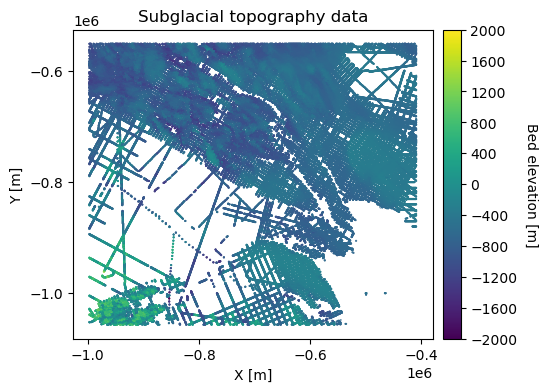

In [6]:
# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()

V_MIN = -2000
V_MAX = 2000

im = ax.scatter(df_bed['x'], df_bed['y'], c=df_bed['bed'], vmin=V_MIN, vmax=V_MAX, 
                     marker='.', s=0.5, cmap='viridis')


plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(V_MIN, V_MAX, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

### Normal score transformation

Geostatistical methods typically require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical interpolation, we will back-transform the interpolation to recover the original distribution.

In [7]:
# normal score transformation
# print(df_bed['bed'].values.shape) OUTPUT: (326071,)

# 1D -> 2D
data = df_bed['bed'].values.reshape(-1,1)
print("Shape of reshaped_bedData:", data.shape)

# Create a new new a normalized transformation
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_bed['Nbed'] = nst_trans.transform(data) 
print("Shape of normalized_bedData:", df_bed['Nbed'].shape)


Shape of reshaped_bedData: (247465, 1)
Shape of normalized_bedData: (247465,)


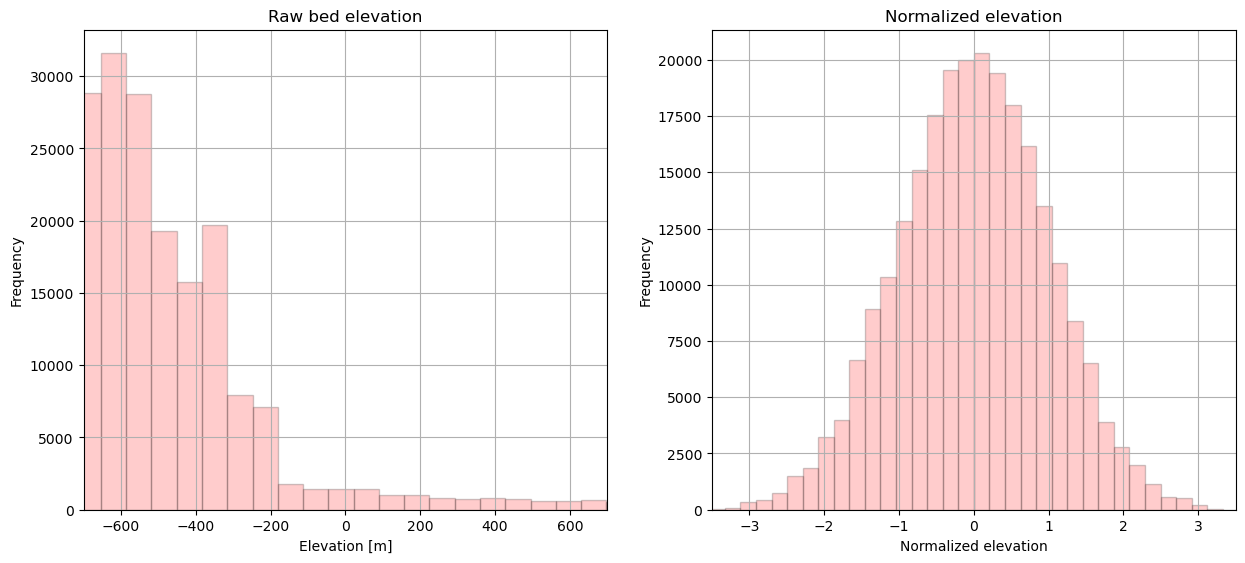

In [8]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_bed['bed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-700,700]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_bed['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

__Q1: How do the before and after transformation histograms compare? Why is this step important?__

Answer: Using the raw and normalized transformation, it helps us understand the elevation standard deviation in our dataset. Specifically, our data deviates at most to the 3rd deviation. 

### Compute the experimental variogram

The variogram is how we "learn" the roughness of the topography.

When computing the variogram, we'll randomly drop out a fraction of the points to speed up the variogram calculation. Don't worry, the variogram will still be fairly robust. You might need to play around with this percentage, depending on how much data you have.

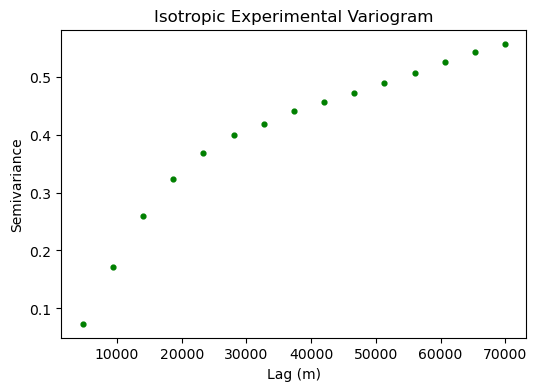

In [9]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df_bed.sample(frac=0.15, random_state=42)

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 70000      # maximum range distance -- Not really a way to determine when to set the number
n_lags = 15         # num of bins (try decreasing if this is takinzg too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

__Q2: By looking at your variogram model, roughly what is your sill and range? What do these parameters represent? Why does the semivariance axis go up to ~1?__

Answer: 
Sill: ~35700
- Where the semivariance plateau, beyond the sill, the points are no longer spatially correlated
Range: 70000
- Range of when spatial corelation exists. Beyond it, the points are more independent

The semivariance go up to one because the data variance (sigma**2) was normalized to [0,1]

### Fit variogram model

Now we need to fit variogram model parameters to the experimental variogram. We will use these model parameters when we perform our simulations.

There are many different variogram model types. We will use the Matern variogram because it has an extra parameter which helps the model fit extra well, and I think this model type tends to produce the most believable looking topography.

Read up on variogram modeling here: https://scikit-gstat.readthedocs.io/en/latest/auto_examples/tutorial_03_variogram_models.html#sphx-glr-auto-examples-tutorial-03-variogram-models-py 

In [ ]:
# use matern variogram model
V1.model = 'matern' 
V1.parameters
# [range, sill, smoothing param, nugget]

# [62945.78690579395, 0.5570000006242971, 0.5611155282713337, 0]


[62945.78690579395, 0.5570000006242971, 0.5611155282713337, 0]

__Q3: Describe each parameter? How does this compare to your guess in Q2?__

Answer: 
- For the lag distance from 0 to 57762, the semivariance is data's variance is correlated within that lag distance, beyond that, they are more independent. 
- The sill levels off at 0.5659
- Smoothing parameter shows that the data is moderately smooth, but not entirely, so there will still be some noise
- The nugget suggests that there are no variance outlier. 

In [11]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_matern = skg.models.matern(xi, V1.parameters[0], V1.parameters[1], V1.parameters[2], V1.parameters[3])


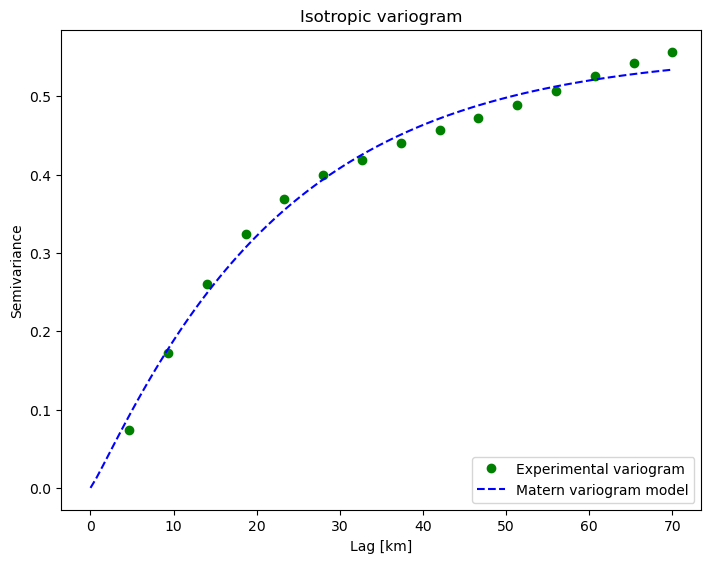

In [12]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000.0,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000.0, y_matern,'b--', label='Matern variogram model')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')



### Now that we have our variogram parameters, we can move on to simulation

First, we need to initialize a simulation grid. This will ensure your data is properly gridded. 

In [13]:
# grid data to 500 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'x', 'y', 'Nbed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Nbed"}) # rename last column

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

pred_grid = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [14]:
df_grid.head()

,X,Y,Sum,Count,Nbed
22,-975250.0,-1056750.0,4.774740,3.0,1.591580
32,-965250.0,-1056750.0,6.961683,5.0,1.392337
33,-964250.0,-1056750.0,2.988043,2.0,1.494022
34,-963250.0,-1056750.0,9.650403,6.0,1.608400
35,-962250.0,-1056750.0,1.567687,1.0,1.567687


Let's set up our simulation. We'll need the variogram parameters, and we als oneed to decide our number of nearest neighboring conditioning points and search radius.

In [15]:
# save variogram parameters as a list
azimuth = 0
nugget = 0 # make nugget 0

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
smoothness = V1.parameters[2]
vtype = 'matern'
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 70000    # 70 km search radius

sim = gs.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'Nbed', k, vario_list, rad, quiet=False, seed=0)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze() # back transformation

## Save our back transform so we don't run this multiple times incase kernel crashes
np.save('sim_trans.npy', sim_trans)
np.save('sim.npy', sim)

100%|██████████| 298034/298034 [55:57<00:00, 88.78it/s]  



In [30]:
"""
np.save('sim_trans.npy', sim_trans)
sim_trans = np.load('sim_trans.npy')

np.save('sim.npy', sim)
sim = np.load('sim.npy')
"""

sim_trans = np.load('sim_trans.npy')
sim = np.load('sim.npy')


sim_trans.size, sim.size

(298034, 298034)

This might take a while! While you are working on the code, you might want to temporarily coarsen the resolution to save time.

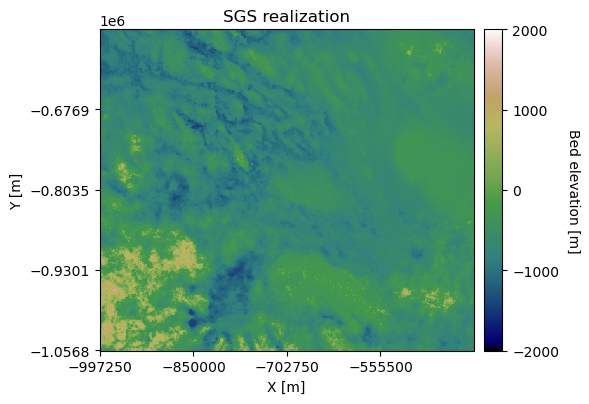

In [19]:
# plot simulation
x_mat = pred_grid[:,0].reshape((rows, cols))
y_mat = pred_grid[:,1].reshape((rows, cols))
sgs_mat = sim_trans.reshape((rows, cols))

fig, ax = plt.subplots(figsize=(6, 5))
V_MIN = -2000
V_MAX = 2000
im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=V_MIN, vmax=V_MAX, cmap='gist_earth')
ax.set_title('SGS realization')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(V_MIN, V_MAX, 5), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)

ax.axis('scaled')

plt.tight_layout()
plt.show()

Load in your BedMachine data and plot the topography for this region.

loading BedMachine dataset
NOTICE! The categorical data in bedmachine will automatically be interpolated using nearest neighbor interpolation method
NOTICE! The categorical data in bedmachine will automatically be interpolated using nearest neighbor interpolation method


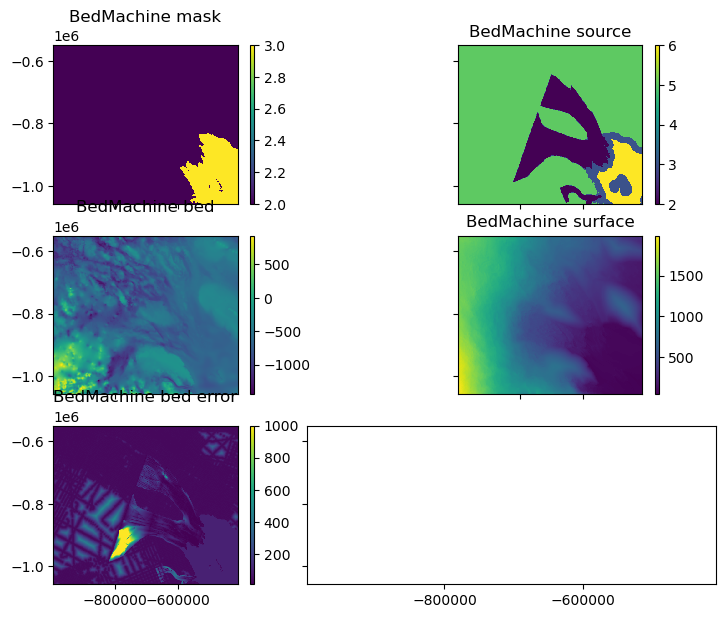

In [18]:
xmin = -997250
xmax = -408250
ymin = -1056750
ymax = -550250
xx, yy = np.meshgrid(np.arange(xmin, xmax, res), 
                     np.arange(ymin, ymax, res))
print('loading BedMachine dataset')
bedmachine_filepath = '/Volumes/tylerleSSD/DEMOGORGN_data/BedMachineAntarctica-v3.nc'
bm_mask, bm_source, bm_bed, bm_surface, bm_errbed, figbm = Topography.load_bedmachine(bedmachine_filepath, xx, yy, res)
figbm



__Q4: Visually, how does your simulated topography compare to BedMachine? Why do they differ?__

Answer: 
First, I changed the VMIN and VMAX of the SGS realization, so that it would match the BedMachine figure. SGS realization has lower and higher extremes (in the 3000 and -3000). This could be due to the fact that SGS introduduces random variability.

Second, BedMachine topography seems to be smoother and continous compared to SGS, which shows more small spots thats shows variability, texture or noisy pattern.

## Variogram comparison

Now you are going to compare the variograms for BedMachine and your simulation. Compute the experimental variograms for both BedMachine and your simulated (back-transformed) topography. Plot the two experimental variograms.

Shape of BedMachine Data Frame:  (298623, 3)


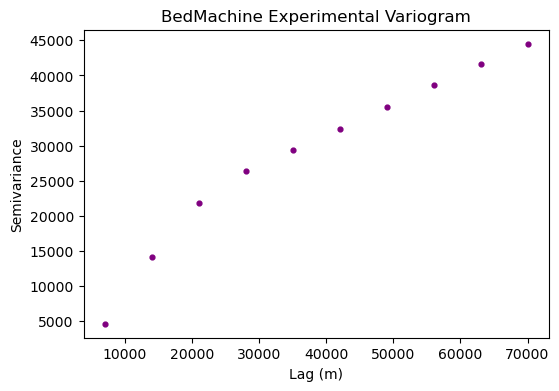

In [20]:
# Intiialize data frame + drop null data 
x_flat, y_flat, z_flat = xx.flatten(), yy.flatten(), bm_bed.flatten()

raw_flat_data = {'x': x_flat, 'y': y_flat, 'Nbed': z_flat}
df_bm = pd.DataFrame(raw_flat_data) \
        .dropna(subset=['Nbed'])
print("Shape of BedMachine Data Frame: ", df_bm.shape)
# Sample data
df_bm_sampled = df_bm.sample(frac=0.10, random_state=42)

# Variogram
coords_bm = df_bm_sampled[['x', 'y']].values
values_bm = df_bm_sampled['Nbed'] 
### Here I divided by 1000 because the bed elevation in BM was measured in Km, here I changed it to [m]

maxlag = 70000
n_lags = 10

V_bm = skg.Variogram(coords_bm, values_bm, bin_func='even', n_lags=n_lags,
                     maxlag=maxlag, normalize=False)

#  Extract bins and experimental semivariances
x_bm = V_bm.bins
y_bm = V_bm.experimental

# STEP 7: Plot 
plt.figure(figsize=(6,4))
plt.scatter(x_bm, y_bm, s=12, c='purple')
plt.title('BedMachine Experimental Variogram')
plt.xlabel('Lag (m)')
plt.ylabel('Semivariance')
plt.show()

In [21]:
#  Extract bins and experimental semivariances
x_bm = V_bm.bins
y_bm = V_bm.experimental

In [22]:
# use matern variogram model
V_bm.model = 'matern' 
V_bm.parameters
# [range, sill, smoothing param, nugget]

[69999.99999999983, 43441.89198806617, 1.0357360070511605, 0]

In [35]:
# Evaluate BM model
xi_bm =np.linspace(0, x_bm[-1], 100) 
bm_matern = skg.models.matern(xi_bm, V_bm.parameters[0], V_bm.parameters[1], V_bm.parameters[2], V_bm.parameters[3])

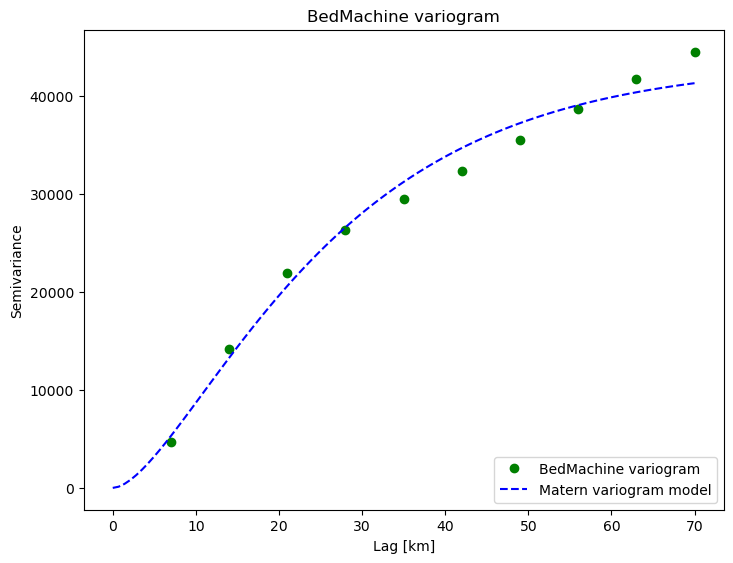

In [36]:
# plot variogram model


fig = plt.figure()
plt.plot(x_bm/1000.0 , y_bm,'og', label = "BedMachine variogram")
plt.plot(xi_bm/1000.0 , bm_matern,'b--', label='Matern variogram model')
plt.title('BedMachine variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

In [30]:
# Intiialize SGS data frame + drop null data 
x_flat, y_flat, z_flat = xx.flatten(), yy.flatten(), sim_trans.flatten()

sgs_raw_flat_data = {'x': x_flat, 'y': y_flat, 'Nbed': z_flat}
df_sgs = pd.DataFrame(raw_flat_data) \
        .dropna(subset=['Nbed'])
print("Shape of SGS Data Frame: ", df_sgs.shape)

Shape of SGS Data Frame:  (298623, 3)


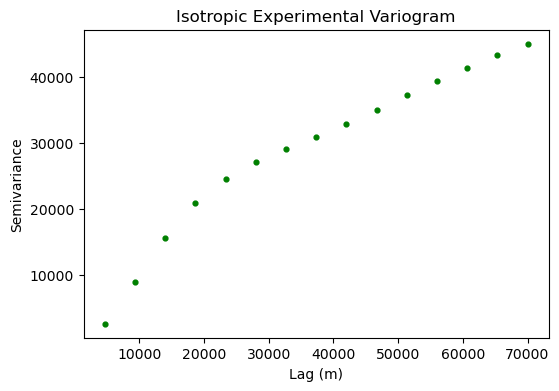

In [ ]:
# SGS Variogram


# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
sgs_sampled = df_sgs.sample(frac=0.15, random_state=42)

# compute experimental (isotropic) variogram
sgs_coords = sgs_sampled[['x','y']].values
sgs_values = sgs_sampled['Nbed']

maxlag = 70000      # maximum range distance -- Not really a way to determine when to set the number
n_lags = 15         # num of bins (try decreasing if this is takinzg too long)

# compute variogram
V_SGS = skg.Variogram(sgs_coords, sgs_values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
sgs_xdata = V_SGS.bins
sgs_ydata = V_SGS.experimental

plt.figure(figsize=(6,4))
plt.scatter(sgs_xdata, sgs_ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [38]:
V_SGS.model = 'matern' 
V_SGS.parameters
# [range, sill, smoothing param, nugget]

[69999.99999999999, 43982.66972532169, 0.8858134079911817, 0]

In [39]:
# Evaluate BM model
xi_sgs =np.linspace(0, sgs_xdata[-1], 100) 
sgs_matern = skg.models.matern(xi_sgs, V_SGS.parameters[0], V_SGS.parameters[1], V_SGS.parameters[2], V_SGS.parameters[3])

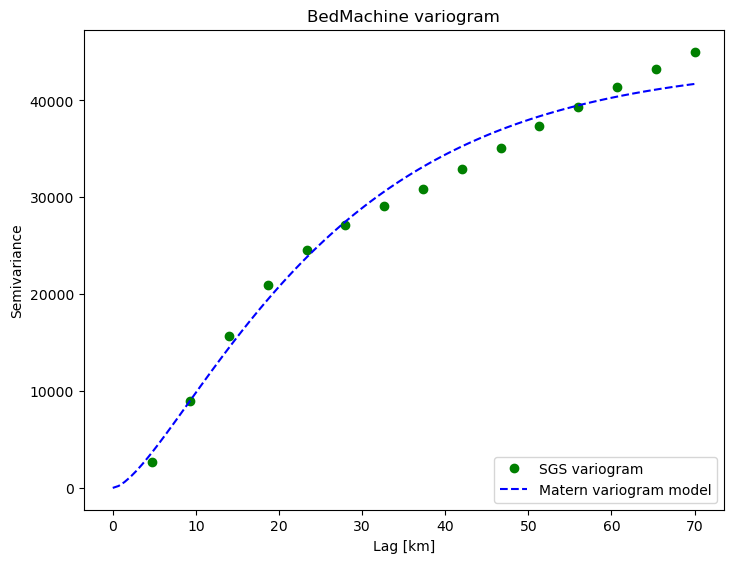

In [40]:
# plot SGS variogram model


fig = plt.figure()
plt.plot(sgs_xdata/1000.0 , sgs_ydata,'og', label = "SGS variogram")
plt.plot(xi_sgs/1000.0 , sgs_matern,'b--', label='Matern variogram model')
plt.title('BedMachine variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

Variogram Matern Parameters: [range, sill, smoothing, nugget]
SGS: [69999.99999999999, 43982.66972532169, 0.8858134079911817, 0]
SGS: [69999.99999999999, 43982.66972532169, 0.8858134079911817, 0]
BedMachine: [69999.99999999983, 43441.89198806617, 1.0357360070511605, 0]
BedMachine: [69999.99999999983, 43441.89198806617, 1.0357360070511605, 0]


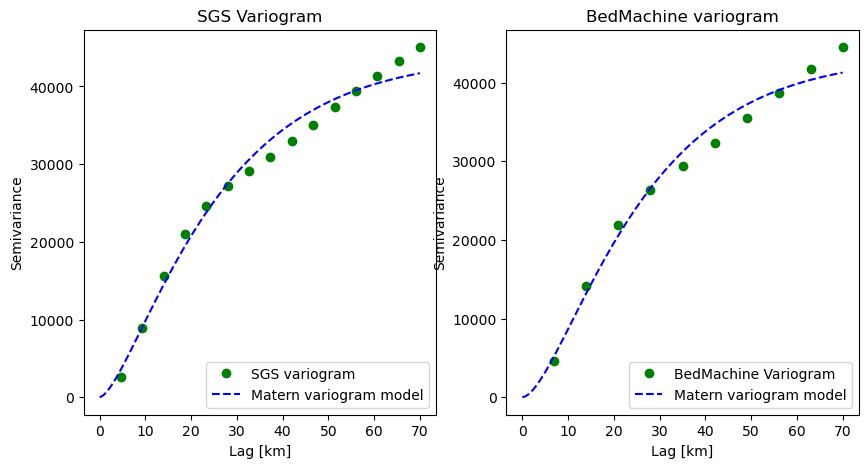

In [43]:
####### Your code here ############
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# --- Plot 1: SGS variogram model ---
axes[0].plot(sgs_xdata/1000.0, sgs_ydata, 'og', label="SGS variogram")
axes[0].plot(xi_sgs/1000.0, sgs_matern, 'b--', label="Matern variogram model")
axes[0].set_title('SGS Variogram')
axes[0].set_xlabel('Lag [km]')
axes[0].set_ylabel('Semivariance')
axes[0].legend(loc='lower right')

axes[1].plot(x_bm/1000.0,y_bm,'og', label = "BedMachine Variogram")
axes[1].plot(xi_bm/1000.0, bm_matern,'b--', label='Matern variogram model')
axes[1].set_title('BedMachine variogram')
axes[1].set_xlabel('Lag [km]') 
axes[1].set_ylabel('Semivariance')  
axes[1].legend(loc='lower right')

print("Variogram Matern Parameters: [range, sill, smoothing, nugget]")
print(f"SGS: {V_SGS.parameters}")
print(f"BedMachine: {V_bm.parameters}")

__Q5: How do the experimental variograms differ? How do you interpret these differences?__

__ [range, sill, smoothing param, nugget]

__V_BM: [69999.99999999983, 43441.89198806617, 1.0357360070511605, 0]

__S_GS: [69999.99999999999, 43982.66972532169, 0.8858134079911817, 0]

Answer: 

The experimental variograms for the SGS simulation (V_SGS) and BedMachine (V_BM) now show a very close match, which was the goal of the simulation. The Sill is nearly identical between the SGS and BM, so similar variance is captured -- further significance test could be done. 

The range is the same for the two matern variograms, which shows that the simulation captured the spatial correlation in BM.

The big difference is the smoothing parameter. SGS is more roughness than BM. 

